In [1]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
import pandas as pd

from featureBuilder import featureBuilder

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


## Build dataframes and variables needed

In [3]:
# Load data from memory
foldername='P001'
filename='part_P001_block_S004'
filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df = loadData(datatype='dataframe', foldername=foldername, filename=filename)

In [4]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9
med_state = ((df["trial_time"] > 0.7) & (df["trial_time"] <= 0.9))

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]
med_df = df[med_state]

In [5]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)
for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
# for row_index,row in med_df.iterrows():
#     dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)

feature_df = pd.DataFrame(dictionary)
len(feature_df)

499

In [6]:
# Needed for visualizing LDA components
colors=['blue', 'orange', 'green']
class_names=["unfocused", "mid_focused", "focused"]

## LDA using sklearn 1 dim (2 possible outputs)
https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [7]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using random forest classifier
    classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + Random Forest accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.59
Accuracy 0.55
Accuracy 0.54
Accuracy 0.61
Accuracy 0.63
Accuracy 0.59
Accuracy 0.65
Accuracy 0.6
Accuracy 0.53
Accuracy 0.55
Avg LDA + Random Forest accuracy: 0.584


## LDA w/ SVM Classifier
https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [8]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using SVM
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + SVM accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.59
Accuracy 0.57
Accuracy 0.59
Accuracy 0.61
Accuracy 0.67
Accuracy 0.58
Accuracy 0.63
Accuracy 0.6
Accuracy 0.53
Accuracy 0.56
Avg LDA + SVM accuracy: 0.593


In [9]:
zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
sorted_zip_list

[(-62.43529642655511, 'average norm_mean_first_difference'),
 (-58.9132707759297, 'left norm_mean_second_difference'),
 (-37.29599629380584, 'right norm_mean_second_difference'),
 (-28.78352912653667, 'left std_voltage'),
 (-20.50969586077612, 'right std_voltage'),
 (-17.150788995201502, 'left mean_first_difference'),
 (-16.962807227049677, 'average mean_first_difference'),
 (-13.604663633263005, 'right mean_first_difference'),
 (-11.62170868646462, 'beta average'),
 (-7.69256295204846, 'alpha right'),
 (-7.229076881344648, 'alpha left'),
 (-6.829549177040478, 'alpha average_power'),
 (-5.638533470181843, 'left_minus_right norm_mean_first_difference'),
 (-3.5842876647153283, 'delta average'),
 (-3.195916798496399, 'theta average'),
 (-3.083466335696043, 'beta left_minus_right'),
 (-2.6640741922855375, 'left_minus_right mean_first_difference'),
 (-2.1770049259288347, 'alpha left_minus_right_power'),
 (-0.8872966342505051, 'theta left_minus_right'),
 (-0.8833729962341819, 'theta/alpha le

LDA explained variance: [1.]


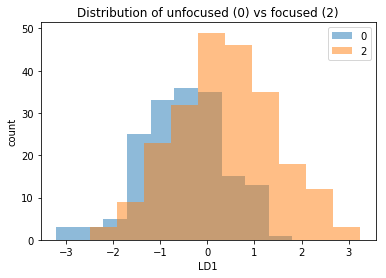

In [10]:
# Visualize LDA model 
print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(X_train, columns=['LDA 1'])
lda_feature_df['focused']=y_train.values

# Plot groups wrt LDA 1 dimension

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.hist(df['LDA 1'].values, alpha=0.5, label=class_name)

plt.xlabel('LD1')
plt.ylabel("count")
plt.title("Distribution of unfocused (0) vs focused (2)")    
plt.legend()
plt.show()

## LDA manual

In [11]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [12]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [13]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [14]:
within_class_scatter_matrix.shape

(64, 64)

In [15]:
between_class_scatter_matrix.shape

(64, 64)

In [16]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [17]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [18]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
print("top 10 eigenvalues")
for pair in pairs[:10]:
    print(pair[0])

top 10 eigenvalues
0.16579159984411
1.0898506192229058e-14
8.222465219358328e-15
8.222465219358328e-15
3.5103069555931423e-15
3.5103069555931423e-15
2.823883651246413e-15
2.823883651246413e-15
1.6509462405521535e-15
1.3563698454276995e-15


In [19]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [20]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

Explained Variance
Eigenvector 0: 1.0000000000000586
Eigenvector 1: 6.573617844617767e-14
Eigenvector 2: 4.959518592673093e-14
Eigenvector 3: 4.959518592673093e-14
Eigenvector 4: 2.1173008517283195e-14
Eigenvector 5: 2.1173008517283195e-14
Eigenvector 6: 1.7032730572006127e-14
Eigenvector 7: 1.7032730572006127e-14
Eigenvector 8: 9.957960729642497e-15
Eigenvector 9: 8.181173513634842e-15
Eigenvector 10: 8.181173513634842e-15
Eigenvector 11: 6.874022423706214e-15
Eigenvector 12: 6.874022423706214e-15
Eigenvector 13: 3.559329724358588e-15
Eigenvector 14: 3.559329724358588e-15
Eigenvector 15: 3.0773835874294802e-15
Eigenvector 16: 3.0773835874294802e-15
Eigenvector 17: 2.5158197217664386e-15
Eigenvector 18: 2.5158197217664386e-15
Eigenvector 19: 2.3813905868835e-15
Eigenvector 20: 2.3813905868835e-15
Eigenvector 21: 1.8425225817140198e-15
Eigenvector 22: 1.0709298586295725e-15
Eigenvector 23: 1.0709298586295725e-15
Eigenvector 24: 1.061456066423099e-15
Eigenvector 25: 1.061456066423099e-15

In [21]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

array([[-4.76636749e-04,  2.86934866e-03],
       [-3.87287560e-04,  2.87991187e-03],
       [-3.37419538e-04,  3.12224025e-03],
       [-1.44683270e-04,  1.90131807e-03],
       [-4.15451773e-04,  3.91252990e-03],
       [-4.23929115e-04,  3.04623995e-03],
       [-5.19644435e-04,  3.77112032e-03],
       [-5.24546614e-04,  2.80617424e-03],
       [-4.32935178e-04,  2.31876058e-03],
       [-1.31949799e-04,  3.53126656e-03],
       [-1.40132246e-04,  2.57042884e-03],
       [-2.30193553e-04,  2.28976240e-03],
       [-2.56086333e-04,  2.42422264e-03],
       [-2.66411954e-04,  3.79586709e-03],
       [-1.67922097e-04,  3.29832355e-03],
       [-2.12378350e-04,  2.55120157e-03],
       [-1.13978690e-04,  1.72375650e-03],
       [-2.07370054e-04,  2.84470324e-03],
       [-3.22289293e-04,  1.55870810e-03],
       [-2.53008337e-04,  1.12664950e-03],
       [-2.78421660e-04,  2.46374968e-03],
       [-2.09037074e-04,  2.15054719e-03],
       [-1.77580377e-04,  2.29165932e-03],
       [-3.

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

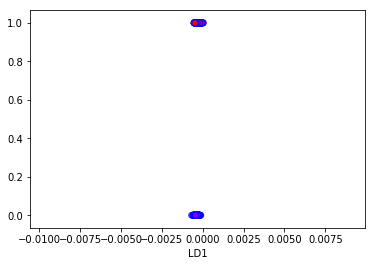

In [23]:
plt.xlabel('LD1')
plt.scatter(
    X_lda[:,0],
    y,
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)